# Building final model

## Imports

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [16]:
import calendar
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from xgboost import XGBClassifier

## Essential Functions for Model Generation

In [17]:
TARGET_VALUE = 'y'

def get_training_data():
    df = pd.read_csv("datasource/bank_data_model.csv")
    return df.iloc[:,1:]

def get_validation_data():
    df =  pd.read_csv("datasource/bank_data_validate.csv")
    return df.iloc[:,1:]

def get_categorical_features(dataFrame): 
    return dataFrame.drop(columns=get_numerical_features(dataFrame)).columns.values

def get_numerical_features(dataFrame):
    return dataFrame.select_dtypes(include=np.number).columns.values

def get_numerical_features_transformer():
    class DayMonthTransformer(BaseEstimator,TransformerMixin):
        def fit(self, X, y=None):
            return self
        
        def transform(self, X):
            X_transformed = X.copy()
            month_num_dict = {month.lower(): index for index, month in enumerate(calendar.month_abbr) if month}
            X_transformed['month'] = X_transformed['month'].map(month_num_dict)
            X_transformed['year'] = np.repeat(2024, repeats= X_transformed.shape[0])
            X_transformed['day_of_the_year'] = pd.to_datetime(X_transformed[["year","month","day"]], format='%d/%m/%y', errors='coerce')
            X_transformed['day_of_the_year'] = X_transformed['day_of_the_year'].apply(lambda x: x.dayofyear)
            return X_transformed.drop(columns=["day", "month", "year"])
        
        def get_feature_names_out(self, input_features = None):
            return ['day_of_the_year']
        
    return ColumnTransformer(
        transformers=[
            ("duration", PowerTransformer(method="yeo-johnson"), ["duration"]),
            ("age", Pipeline( steps = [
                                ("age_power_transform", PowerTransformer(method="box-cox")),
                                ("age_function_transform", FunctionTransformer(lambda col : col + abs(np.min(col)), feature_names_out='one-to-one'))
                                ]
                            ),
            ["age"]),
            ("balance", Pipeline( steps = [
                                ("balance_function_transform_min", FunctionTransformer(lambda col : col + abs(np.min(col)),feature_names_out='one-to-one')),
                                ("balance_function_transform_log", FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
                                ]
                            ),
            ["balance"]),
            ("day_of_the_year", DayMonthTransformer(), ["day","month"])
            ]
        )
                        
def get_categorical_features_transformer():
    return ColumnTransformer(
        transformers= [
            ("yes_no_variables",  OrdinalEncoder(), ["default", "housing", "loan"]),
            ("sorted_variables", Pipeline(
                steps=[
                    ("ordinal", OrdinalEncoder()),
                    ("min_max_scaler", MinMaxScaler())
                ]
            ),
            ["education", "marital", "poutcome"]),
            ("unsorted_variables", OneHotEncoder(), ["job", "contact"]),
        ]
    )  

def get_features_transformer():
    return ColumnTransformer(
        transformers = [
            ("num", get_numerical_features_transformer(), ["duration","balance", "age", "day", "month"]),
            ("cat", get_categorical_features_transformer(), ["default", "housing", "loan", "education", "marital", "poutcome", "job", "contact"]),
            ("others", FunctionTransformer(feature_names_out='one-to-one'), ["campaign", "pdays","previous"])
        ]
    )

def get_estimator(weights):
    return XGBClassifier(booster= 'gbtree', 
                         eta= 0.10987358313376537,
                         max_delta_step= 1.446953199095078, 
                         max_depth= 4, 
                         min_child_weight= 1.666061864206202, 
                         objective= 'binary:logistic', 
                         scale_pos_weight= weights, 
                         tree_method= 'exact')
def get_model(weights):
    return Pipeline(
        steps = [
            ("preprocessor", get_features_transformer()),
            ("estimator", get_estimator(weights))
        ]
    )

def printMetrics(test, pred): 
    cm = confusion_matrix(test,pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cm_display.plot()
    print(f"accuracy : {accuracy_score(test, pred)}")
    print(f"f1       : {f1_score(test, pred)}")
    print(f"precision: {precision_score(test, pred)}")
    print(f"recall   : {recall_score(test, pred)}")
    print(f"roc_auc  : {roc_auc_score(test,pred)}")

## Loading raw data. Data split. Target variable encoding

In [18]:
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split

df = get_training_data()
le = LabelEncoder()
df[TARGET_VALUE] = le.fit_transform(df[TARGET_VALUE])

X_train, X_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df[TARGET_VALUE],
    random_state=42,
)

y_train, y_test = X_train[TARGET_VALUE], X_test[TARGET_VALUE]
X_train, X_test = X_train.drop(columns=TARGET_VALUE), X_test.drop(columns=TARGET_VALUE)

## Model generation

In [19]:
positive = y_train.sum()
negative = y_train.count() - positive
clf = get_model(negative/positive)

In [20]:
clf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  ColumnTransformer(transformers=[('duration',
                                                                                   PowerTransformer(),
                                                                                   ['duration']),
                                                                                  ('age',
                                                                                   Pipeline(steps=[('age_power_transform',
                                                                                                    PowerTransformer(method='box-cox')),
                                                                                                   ('age_function_transform',
                                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                        func=<function get_numerical_features_transf...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None,
                               max_delta_step=1.446953199095078, max_depth=4,
                               max_leaves=None,
                               min_child_weight=1.666061864206202, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [21]:
clf[:-1].get_feature_names_out()

array(['num__duration__duration', 'num__age__age',
       'num__balance__balance', 'num__day_of_the_year__day_of_the_year',
       'cat__yes_no_variables__default', 'cat__yes_no_variables__housing',
       'cat__yes_no_variables__loan', 'cat__sorted_variables__education',
       'cat__sorted_variables__marital',
       'cat__sorted_variables__poutcome',
       'cat__unsorted_variables__job_admin.',
       'cat__unsorted_variables__job_blue-collar',
       'cat__unsorted_variables__job_entrepreneur',
       'cat__unsorted_variables__job_housemaid',
       'cat__unsorted_variables__job_management',
       'cat__unsorted_variables__job_retired',
       'cat__unsorted_variables__job_self-employed',
       'cat__unsorted_variables__job_services',
       'cat__unsorted_variables__job_student',
       'cat__unsorted_variables__job_technician',
       'cat__unsorted_variables__job_unemployed',
       'cat__unsorted_variables__job_unknown',
       'cat__unsorted_variables__contact_cellular',
  

## Model test

accuracy : 0.8715469613259669
f1       : 0.5507246376811594
precision: 0.4596774193548387
recall   : 0.6867469879518072
roc_auc  : 0.7911114034922843


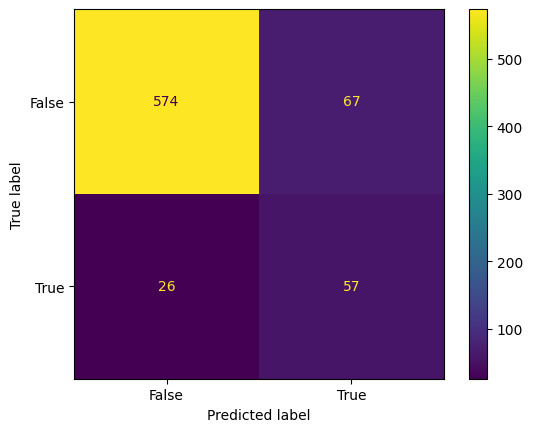

In [22]:
y_hat = clf.predict(X_test)
printMetrics(y_test, y_hat)

In [23]:
import dalex as dx

In [24]:
exp = dx.Explainer(clf, X_train, y_train)
mp = exp.model_performance(model_type = 'classification')

Preparation of a new explainer is initiated

  -> data              : 2892 rows 16 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2892 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fe50cd17040> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000594, mean = 0.234, max = 0.987
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.932, mean = -0.119, max = 0.694
  -> model_info        : package sklearn

A new explainer has been created!


In [25]:
mp.plot(geom="roc")

In [26]:
mp.result

,recall,precision,f1,accuracy,auc
XGBClassifier,0.973054,0.581395,0.727884,0.915975,0.985375


In [27]:
mp.plot()

In [28]:
vi = exp.model_parts(N = None, B = 20, random_state=42)
vi.plot()